<a href="https://colab.research.google.com/github/hwanin99/NLP_Study/blob/main/11_CNN%20%EC%8A%A4%ED%8C%B8%20%EB%A9%94%EC%9D%BC%20%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN 스팸 메일 분류

### 데이터 로드 및 전처리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

* https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

In [ ]:
import urllib.request

urllib.request.urlretrieve('https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv',filename='spam.csv')
data=pd.read_csv('spam.csv',encoding='latin-1')
len(data)

5572

In [ ]:
data[:10]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [ ]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1']=data['v1'].replace(['ham','spam'],[0,1])
data[:10]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [ ]:
data.drop_duplicates(subset=['v2'],inplace=True)
len(data)

5169

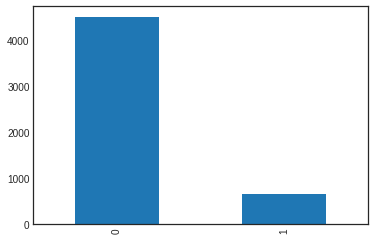

In [ ]:
data['v1'].value_counts().plot(kind='bar');

In [ ]:
data.groupby('v1').size().reset_index(name='count')

,v1,count
0,0,4516
1,1,653


In [ ]:
x_data=data['v2']
y_data=data['v1']

In [ ]:
vocab_size=1000
tokenizer=Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_data)
sequences=tokenizer.texts_to_sequences(x_data)

In [ ]:
sequences[:2]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6]]

In [ ]:
x_data=sequences

print('메일 최대 길이: {}'.format(max(len(l) for l in x_data)))
print('메일 평균 길이: {}'.format((sum(map(len,x_data))/len(x_data))))

메일 최대 길이: 172
메일 평균 길이: 12.566840781582512


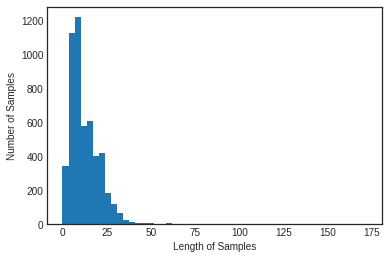

In [ ]:
plt.hist([len(s) for s in x_data],bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
max_len=60
data=pad_sequences(x_data,maxlen=max_len)
print(data.shape)

(5169, 60)


In [ ]:
n_train=int(len(sequences)*0.8)
n_test=int(len(sequences)-n_train)

print(n_train)
print(n_test)

4135
1034


In [ ]:
x_train=data[:n_train]
y_train=np.array(y_data[:n_train])
x_test=data[n_train:]
y_test=np.array(y_data[n_train:])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


### 모델 구성

In [ ]:
from tensorflow.keras.layers import Dense,Conv1D,GlobalMaxPooling1D,Embedding,Dropout,MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [ ]:
model=Sequential()
model.add(Embedding(vocab_size,32))
model.add(Dropout(0.2))
model.add(Conv1D(32,5,strides=1,padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32000     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          5152      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc=ModelCheckpoint('best_model.h5',monitor='val_acc',model='max',verbose=1,save_best_only=True)

### 모델 학습

In [ ]:
history=model.fit(x_train,y_train,
                  epochs=10,
                  batch_size=64,
                  validation_split=0.2,
                  callbacks=[es,mc])

Epoch 1/10
52/52 [==============================] - 9s 10ms/step - loss: 0.5065 - acc: 0.8479 - val_loss: 0.3792 - val_acc: 0.8730
Epoch 2/10
52/52 [==============================] - 0s 5ms/step - loss: 0.3853 - acc: 0.8697 - val_loss: 0.3528 - val_acc: 0.8730
Epoch 3/10
52/52 [==============================] - 0s 6ms/step - loss: 0.2333 - acc: 0.9117 - val_loss: 0.0927 - val_acc: 0.9794
Epoch 4/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0654 - acc: 0.9837 - val_loss: 0.0544 - val_acc: 0.9879
Epoch 5/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0406 - acc: 0.9879 - val_loss: 0.0495 - val_acc: 0.9843
Epoch 6/10
52/52 [==============================] - 0s 5ms/step - loss: 0.0286 - acc: 0.9921 - val_loss: 0.0493 - val_acc: 0.9855
Epoch 7/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0190 - acc: 0.9943 - val_loss: 0.0486 - val_acc: 0.9843
Epoch 8/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0140 - acc: 0.9

### 시각화

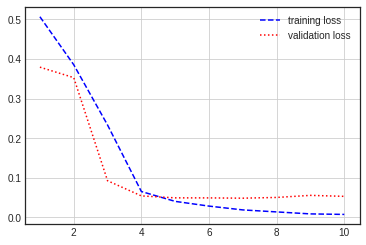

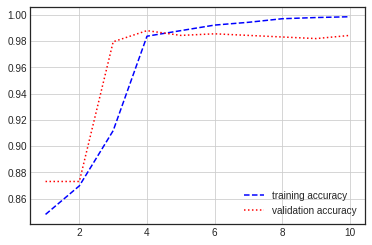

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['acc']
val_acc=history.history['val_acc']

epochs=range(1,len(loss)+1)

plt.plot(epochs,loss,'b--',label='training loss')
plt.plot(epochs,val_loss,'r:',label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,acc,'b--',label='training accuracy')
plt.plot(epochs,val_acc,'r:',label='validation accuracy')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model.evaluate(x_test,y_test)

33/33 [==============================] - 0s 3ms/step - loss: 0.0588 - acc: 0.9816


[0.05876569449901581, 0.9816247820854187]